# Avaliando o preço de automóveis - Parte 2
Otimizar o modelo para atingir uma melhor acurácia.
## Importando dados

In [1]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


### Criando uma situação de azar para o modelo

In [2]:
dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


## Modelos básicos
### DummyClassifier para referência

In [3]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


### Modelo de Árvore de decisão com Validação Cruzada

In [4]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


### Adicionando uma categoria de agrupamento

In [5]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [6]:
def imprime_resultados(results):
    media = results['test_score'].mean() * 100
    desvio = results['test_score'].std() * 100
    print("Accuracy médio %.2f" % media)
    print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

### Analisando o modelo com novos grupos

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [12]:
cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


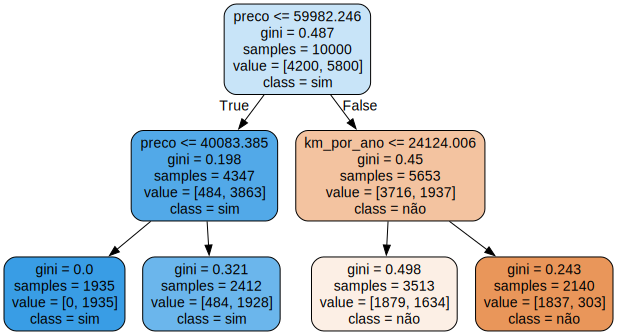

In [13]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

In [14]:
cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


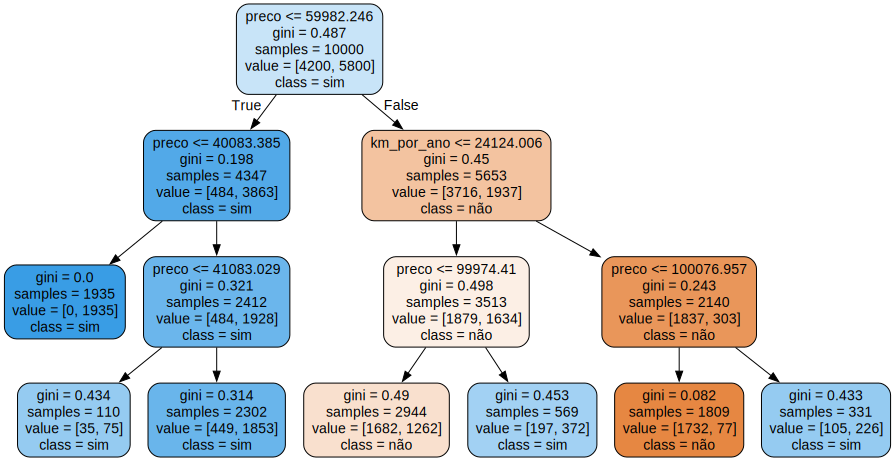

In [15]:
modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

In [16]:
cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 77.21
Intervalo [75.33, 79.10]


## Testando hiper parêmetros
### Explorando hiper parâmetros em uma dimensão

In [17]:
def roda_arvore_de_decisao(max_depth):
    SEED = 301
    np.random.seed(SEED)
    
    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    print("Arvore max_depth = %d, treino = %.2f, teste = %.2f" % (max_depth, train_score, test_score))
    tabela = [max_depth, train_score, test_score]
    return tabela
    
resultados = [roda_arvore_de_decisao(i) for i in range(1,33)]
resultados = pd.DataFrame(resultados, columns= ["max_depth","train","test"])
resultados.head()

Arvore max_depth = 1, treino = 75.79, teste = 75.78
Arvore max_depth = 2, treino = 75.79, teste = 75.78
Arvore max_depth = 3, treino = 78.75, teste = 78.67
Arvore max_depth = 4, treino = 78.79, teste = 78.63
Arvore max_depth = 5, treino = 78.94, teste = 78.56
Arvore max_depth = 6, treino = 79.17, teste = 78.12
Arvore max_depth = 7, treino = 79.50, teste = 77.96
Arvore max_depth = 8, treino = 79.89, teste = 77.86
Arvore max_depth = 9, treino = 80.46, teste = 77.38
Arvore max_depth = 10, treino = 81.16, teste = 77.19
Arvore max_depth = 11, treino = 82.03, teste = 76.97
Arvore max_depth = 12, treino = 82.89, teste = 76.49
Arvore max_depth = 13, treino = 83.95, teste = 75.81
Arvore max_depth = 14, treino = 85.03, teste = 75.66
Arvore max_depth = 15, treino = 86.14, teste = 75.16
Arvore max_depth = 16, treino = 87.19, teste = 75.11
Arvore max_depth = 17, treino = 88.31, teste = 74.74
Arvore max_depth = 18, treino = 89.26, teste = 74.33
Arvore max_depth = 19, treino = 90.32, teste = 74.34
Ar

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


### OVERFIT: ficou "perfeito" para o treino mas ruim para o teste

<Axes: xlabel='max_depth', ylabel='train'>

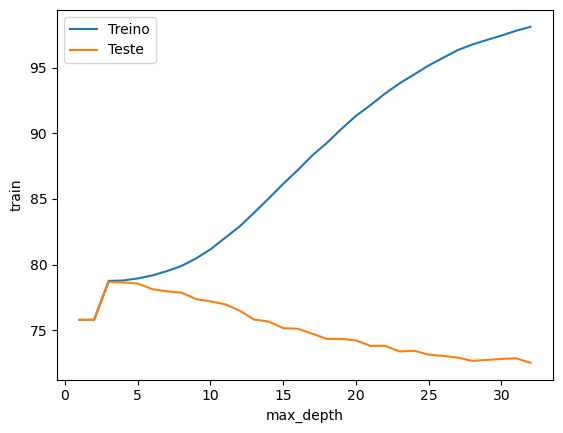

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x = "max_depth", y = "train", data = resultados, label="Treino")
sns.lineplot(x = "max_depth", y = "test", data = resultados, label="Teste")

In [20]:
resultados.sort_values("test", ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


### Explorando hiper parâmetros em 2 dimensões

In [21]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)
  
    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    print("Arvore max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, train_score, test_score))
    tabela = [max_depth, min_samples_leaf, train_score, test_score]
    return tabela

def busca():
    resultados = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32, 64, 128, 256]:
            tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
            resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
    return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 64, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Arvore max_depth = 4, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 

,max_depth,min_samples_leaf,train,test
0,1,32,75.791169,75.784219
1,1,64,75.791169,75.784219
2,1,128,75.791169,75.784219
3,1,256,75.791169,75.784219
4,2,32,75.791169,75.784219


In [22]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
15,4,256,78.750993,78.672633
12,4,32,78.750993,78.672633
14,4,128,78.750993,78.672633
13,4,64,78.750993,78.672633
8,3,32,78.750993,78.672633


In [23]:
pd.set_option('display.float_format', '{:.5f}'.format)
corr = resultados.corr(numeric_only=True)
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.00000,-0.00000,0.53670,-0.02768
min_samples_leaf,-0.00000,1.00000,-0.40968,0.34901
train,0.53670,-0.40968,1.00000,0.11647
test,-0.02768,0.34901,0.11647,1.00000


<Axes: >

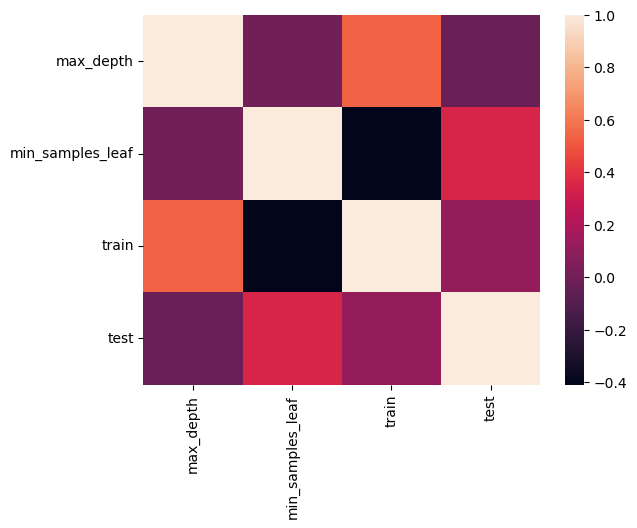

In [24]:
sns.heatmap(corr)

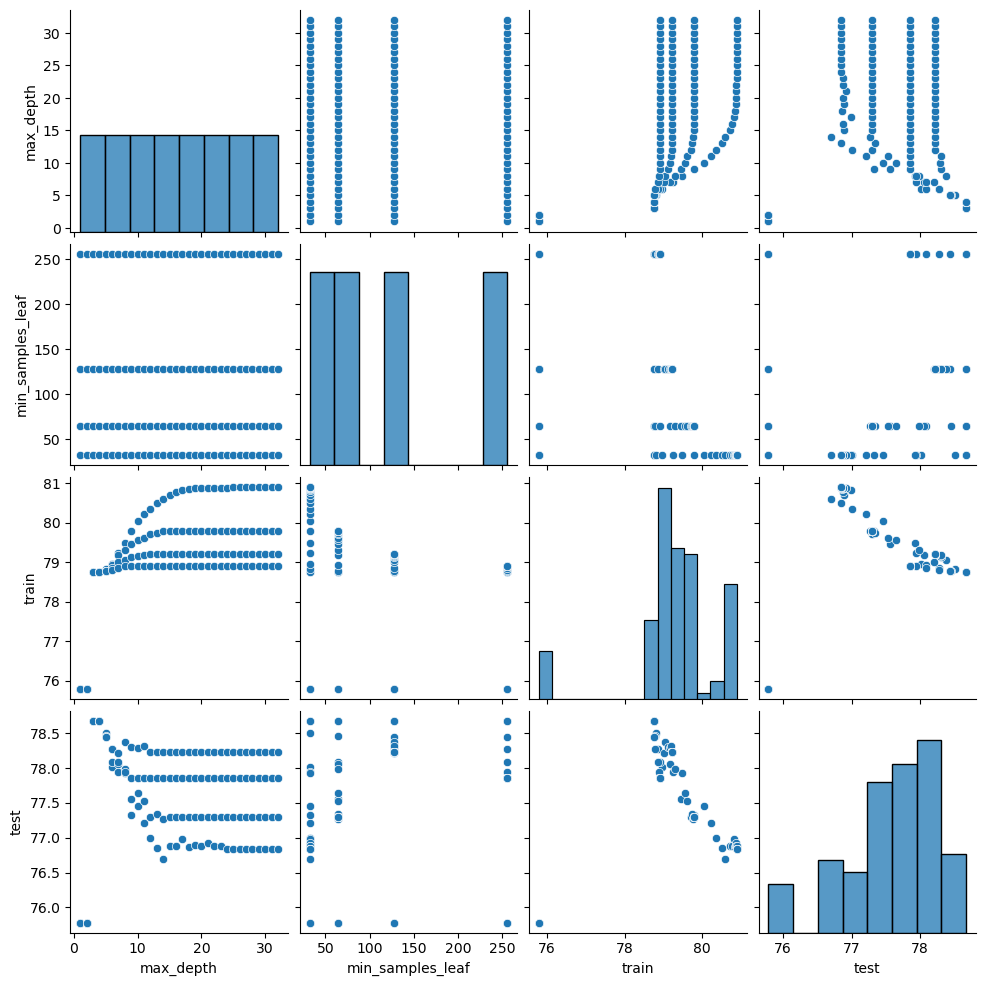

In [25]:
sns.pairplot(resultados)

<Axes: >

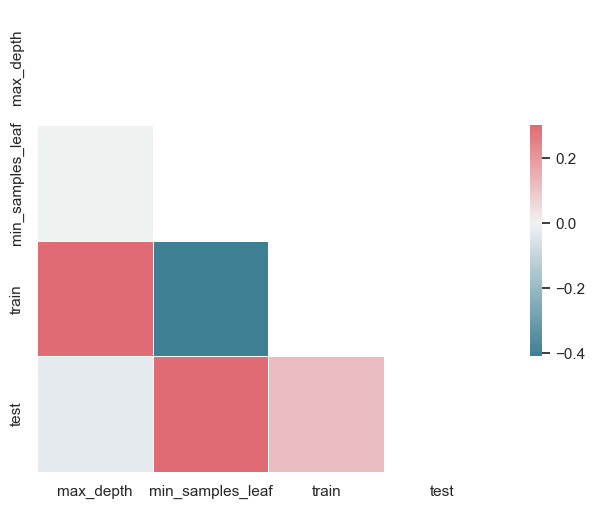

In [27]:
sns.set(style="white")

mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(8, 6))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [28]:
def busca():
    resultados = []
    for max_depth in range(1,33):
        for min_samples_leaf in [128, 192, 256, 512]:
            tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
            resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
    return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 192, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 512, treino = 77.53, teste = 77.50
Arvore max_depth = 4, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_d

,max_depth,min_samples_leaf,train,test
0,1,128,75.79117,75.78422
1,1,192,75.79117,75.78422
2,1,256,75.79117,75.78422
3,1,512,75.79117,75.78422
4,2,128,75.79117,75.78422


In [29]:
corr = resultados.corr()

<Axes: >

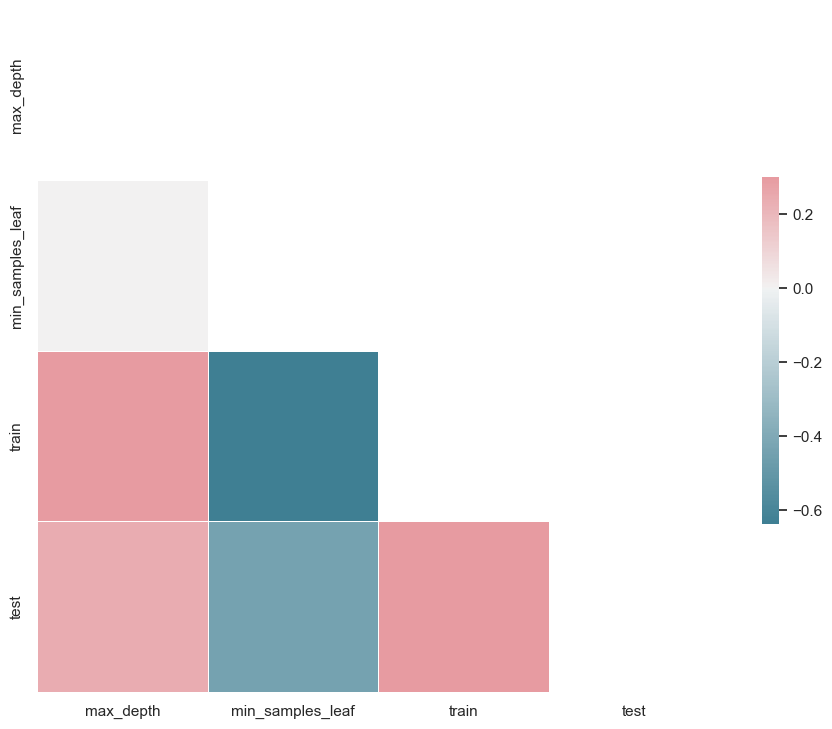

In [31]:
sns.set(style="white")

mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [32]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
13,4,192,78.75099,78.67263
8,3,128,78.75099,78.67263
9,3,192,78.75099,78.67263
10,3,256,78.75099,78.67263
14,4,256,78.75099,78.67263


### Explorando espaço de hiper parâmetros com GridSearchCV

In [33]:
from sklearn.model_selection import GridSearchCV

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits = 10))
busca.fit(x_azar, y_azar, groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.01727,0.00363,0.00121,0.00258,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.80476,...,0.78408,0.78318,0.79781,0.76287,0.78182,0.77551,0.79026,0.78673,0.01136,1
1,0.01602,0.00359,0.00062,0.00141,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.80476,...,0.78408,0.78318,0.79781,0.76287,0.78182,0.77551,0.79026,0.78673,0.01136,1
2,0.01651,0.00234,0.00115,0.00285,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.80476,...,0.78408,0.78318,0.79781,0.76287,0.78182,0.77551,0.79026,0.78673,0.01136,1
3,0.01405,0.00366,0.00278,0.00353,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.80476,...,0.78408,0.78318,0.79781,0.76287,0.78182,0.77551,0.79026,0.78673,0.01136,1
4,0.01710,0.00492,0.00061,0.00182,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.80476,...,0.78408,0.78318,0.79781,0.76287,0.78182,0.77551,0.79026,0.78673,0.01136,1


In [34]:
resultados.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_max_depth', 'param_min_samples_leaf',
       'param_min_samples_split', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [35]:
# pd.DataFrame.sort_values(by='mean_test_score')
resultados[resultados['rank_test_score'] == 1].sort_values(by='mean_fit_time')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
3,0.01405,0.00366,0.00278,0.00353,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.80476,...,0.78408,0.78318,0.79781,0.76287,0.78182,0.77551,0.79026,0.78673,0.01136,1
5,0.01488,0.00318,0.00409,0.00644,gini,3,64,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.80476,...,0.78408,0.78318,0.79781,0.76287,0.78182,0.77551,0.79026,0.78673,0.01136,1
7,0.01515,0.00220,0.00306,0.00513,gini,3,128,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.80476,...,0.78408,0.78318,0.79781,0.76287,0.78182,0.77551,0.79026,0.78673,0.01136,1
6,0.01528,0.00130,0.00202,0.00474,gini,3,128,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.80476,...,0.78408,0.78318,0.79781,0.76287,0.78182,0.77551,0.79026,0.78673,0.01136,1
1,0.01602,0.00359,0.00062,0.00141,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.80476,...,0.78408,0.78318,0.79781,0.76287,0.78182,0.77551,0.79026,0.78673,0.01136,1
2,0.01651,0.00234,0.00115,0.00285,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.80476,...,0.78408,0.78318,0.79781,0.76287,0.78182,0.77551,0.79026,0.78673,0.01136,1
21,0.01676,0.00626,0.00404,0.00567,entropy,3,64,32,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.80476,...,0.78408,0.78318,0.79781,0.76287,0.78182,0.77551,0.79026,0.78673,0.01136,1
4,0.01710,0.00492,0.00061,0.00182,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.80476,...,0.78408,0.78318,0.79781,0.76287,0.78182,0.77551,0.79026,0.78673,0.01136,1
26,0.01711,0.00548,0.00482,0.00618,entropy,3,128,128,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.80476,...,0.78408,0.78318,0.79781,0.76287,0.78182,0.77551,0.79026,0.78673,0.01136,1
25,0.01714,0.00373,0.00156,0.00467,entropy,3,128,64,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.80476,...,0.78408,0.78318,0.79781,0.76287,0.78182,0.77551,0.79026,0.78673,0.01136,1


In [36]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [37]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [38]:
from sklearn.metrics import accuracy_score

# evitar essa abordagem pois estará sendo otimista

predicoes = melhor.predict(x_azar)
accuracy = accuracy_score(predicoes, y_azar) * 100
print("Accuracy para os dados foi %.2f%%" % accuracy)

Accuracy para os dados foi 78.75%


## Como ter uma estimativa sem esse vício nos dados que eu já vi?
No caso de cross validation com busca de hiper parâmetros, fazemos uma nova validação cruzada. Chama-se nested cross validation.

### Infelizmente como o Pandas não suporta nested validation com group k fold não conseguimos prever o resultado para novos grupos

In [40]:
from sklearn.model_selection import GridSearchCV, KFold

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.01958,0.00436,0.00271,0.00061,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.78400,0.77600,0.80250,0.79300,0.77950,0.78700,0.00962,1
1,0.01947,0.00705,0.00221,0.00135,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.78400,0.77600,0.80250,0.79300,0.77950,0.78700,0.00962,1
2,0.01385,0.00263,0.00141,0.00080,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.78400,0.77600,0.80250,0.79300,0.77950,0.78700,0.00962,1
3,0.01572,0.00368,0.00201,0.00261,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.78400,0.77600,0.80250,0.79300,0.77950,0.78700,0.00962,1
4,0.01437,0.00471,0.00080,0.00099,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.78400,0.77600,0.80250,0.79300,0.77950,0.78700,0.00962,1


In [41]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

In [42]:
def imprime_score(scores):
    media = scores.mean() * 100
    desvio = scores.std() * 100
    print("Accuracy médio %.2f" % media)
    print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))
     
imprime_score(scores)

Accuracy médio 78.67
Intervalo [76.80, 80.54]


In [43]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

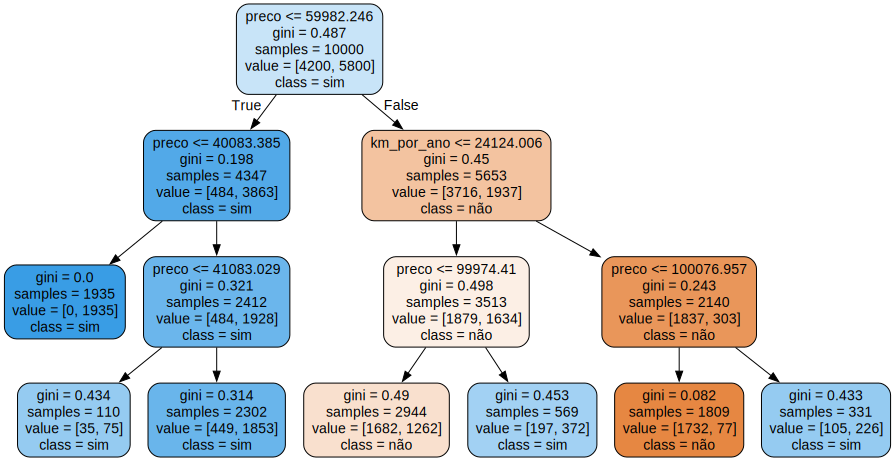

In [44]:
from sklearn.tree import export_graphviz
import graphviz

features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

## Busca aleatória: RandomSearch

In [45]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV, KFold

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    n_iter = 16,
                    cv = KFold(n_splits = 5, shuffle=True),
                    random_state = SEED)
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.01561,0.00036,0.00625,0.00766,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.78400,0.76900,0.79850,0.79300,0.77300,0.78350,0.01128,13
1,0.01513,0.00103,0.00373,0.00604,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.78400,0.77600,0.80250,0.79300,0.77950,0.78700,0.00962,1
2,0.01470,0.00169,0.00098,0.00123,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.78400,0.77600,0.80250,0.79300,0.77950,0.78700,0.00962,1
3,0.02330,0.00636,0.00092,0.00115,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.78400,0.76900,0.80050,0.79300,0.77300,0.78390,0.01183,7
4,0.02508,0.00756,0.00000,0.00000,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.78400,0.76900,0.80050,0.79300,0.77300,0.78390,0.01183,7


In [46]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)

Accuracy médio 78.71
Intervalo [77.49, 79.93]


In [47]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=64)

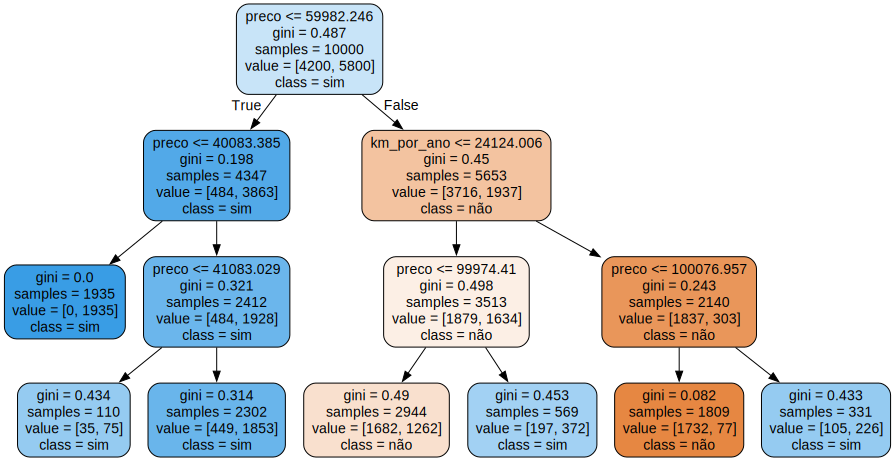

In [48]:
from sklearn.tree import export_graphviz
import graphviz

features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)
graph = graphviz.Source(dot_data)
graph

## Customizando o espaço de hiper parâmetros

In [49]:
from scipy.stats import randint

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None],
    "min_samples_split" : randint(32, 128),
    "min_samples_leaf" : randint(32, 128),
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    n_iter = 16,
                    cv = KFold(n_splits = 5, shuffle=True),
                    random_state = SEED)
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.01660,0.00659,0.00336,0.00369,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.78400,0.77600,0.80250,0.79300,0.77950,0.78700,0.00962,1
1,0.02445,0.00758,0.00364,0.00632,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.77400,0.77250,0.78300,0.78050,0.77250,0.77650,0.00439,14
2,0.02643,0.00913,0.00353,0.00610,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.77050,0.77450,0.79900,0.77900,0.77350,0.77930,0.01022,8
3,0.03032,0.00778,0.00702,0.00862,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.75750,0.77300,0.77250,0.78350,0.75600,0.76850,0.01038,16
4,0.02266,0.00697,0.00000,0.00000,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.77050,0.77350,0.79950,0.77900,0.77450,0.77940,0.01041,7


In [50]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)
melhor = busca.best_estimator_
melhor

Accuracy médio 78.71
Intervalo [77.49, 79.93]


DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=71,
                       min_samples_split=100)

In [51]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.784 +-(0.024) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
0.784 +-(0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.781 +-(0.017) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
0.780 +-(0.019) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 125, 'min_samples_split': 59}
0.780 +-(0.012) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 103, 'min_samples_split': 96}
0.779 +-(0.021) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 126, 'min_samples_split': 84}
0.779 +-(0.020) {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 124, 'min_samples_split': 88}
0.779 +-(0.009) {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 101, 'min_samples_split': 52}
0.779 +-(0.014) {'criterion': 'entropy', 'max_depth

## Uma exploração mais a fundo de forma aleatória

In [52]:
from scipy.stats import randint

SEED=564
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None],
    "min_samples_split" : randint(32, 128),
    "min_samples_leaf" : randint(32, 128),
    "criterion" : ["gini", "entropy"]
}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    n_iter = 64,
                    cv = KFold(n_splits = 5, shuffle=True),
                    random_state = SEED)
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.03506,0.00075,0.00235,0.00069,entropy,None,84,103,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.77800,0.77450,0.77350,0.76200,0.76250,0.77010,0.00658,62
1,0.01481,0.00070,0.00160,0.00049,gini,3,53,60,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.79050,0.78550,0.79150,0.79050,0.77650,0.78690,0.00561,1
2,0.02621,0.00072,0.00214,0.00026,gini,30,118,61,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.77750,0.77450,0.77850,0.77200,0.78750,0.77800,0.00527,18
3,0.03974,0.00092,0.00197,0.00011,entropy,None,53,85,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.77100,0.77800,0.77600,0.76500,0.76550,0.77110,0.00530,57
4,0.03162,0.00061,0.00197,0.00017,gini,10,44,67,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.77550,0.77800,0.78350,0.76950,0.77350,0.77600,0.00467,29


In [53]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.787 +-(0.011) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 33, 'min_samples_split': 77}
0.787 +-(0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 38, 'min_samples_split': 113}
0.787 +-(0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 53, 'min_samples_split': 60}
0.787 +-(0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 61, 'min_samples_split': 86}
0.787 +-(0.011) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 49, 'min_samples_split': 58}
0.787 +-(0.011) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 58, 'min_samples_split': 118}
0.787 +-(0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 122, 'min_samples_split': 117}
0.786 +-(0.013) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 39, 'min_samples_split': 73}
0.786 +-(0.013) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 45, 'min_samples_split': 65}
0.786 +-(0.014) {'criterion': 'entropy', 'max_depth': 5, 

In [54]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)
melhor = busca.best_estimator_
melhor

Accuracy médio 78.69
Intervalo [77.64, 79.74]


DecisionTreeClassifier(max_depth=3, min_samples_leaf=53, min_samples_split=60)

## Comparando GridSearchCV com RandomizedSearch (1 comparação)

In [55]:
from sklearn.ensemble import RandomForestClassifier
import time

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

tic = time.time()
busca = GridSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)


resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 278.44 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.04902,0.00521,0.00926,0.00757,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.77450,0.75600,0.74900,0.78500,0.74500,0.76190,0.01536,130
1,0.53775,0.03861,0.02398,0.00874,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.76550,0.75550,0.79450,0.78500,0.76250,0.77260,0.01468,93
2,0.05165,0.00976,0.00634,0.00641,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.77800,0.76350,0.78350,0.78450,0.75600,0.77310,0.01137,89
3,0.51862,0.01254,0.01847,0.00669,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.74250,0.75500,0.79500,0.78500,0.76200,0.76790,0.01936,119
4,0.05219,0.00600,0.00543,0.00677,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.77550,0.74050,0.74850,0.77600,0.76300,0.76070,0.01425,135


In [56]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.780 +-(0.020) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.020) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.778 +-(0.030) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.027) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.033) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}


In [57]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

Tempo 1251.28 segundos
Accuracy médio 76.78
Intervalo [75.74, 77.82]
RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=32,
                       min_samples_split=64, n_estimators=10)


In [58]:
espaco_de_parametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 20,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)


resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 50.60 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.96700,0.18445,0.05062,0.02647,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.77100,0.77400,0.79250,0.77750,0.75600,0.77420,0.01172,10
1,0.17129,0.05381,0.01384,0.00305,10,32,128,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.75000,0.77850,0.78200,0.77850,0.76450,0.77070,0.01197,13
2,0.96392,0.13205,0.02850,0.00604,100,32,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.77100,0.77450,0.79300,0.77850,0.75850,0.77510,0.01118,6
3,0.05697,0.00514,0.00703,0.00558,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.75000,0.76000,0.74500,0.73900,0.75200,0.74920,0.00703,20
4,0.07022,0.00436,0.00655,0.00455,10,64,32,3,entropy,False,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.77100,0.77400,0.76350,0.73700,0.75850,0.76080,0.01309,18


In [59]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.776 +-(0.025) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.776 +-(0.023) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 128, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
0.776 +-(0.024) {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.776 +-(0.032) {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}
0.775 +-(0.035) {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}


In [60]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

Tempo 203.25 segundos
Accuracy médio 77.59
Intervalo [76.47, 78.71]
RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=32,
                       min_samples_split=32)


In [61]:
espaco_de_parametros = {
    "n_estimators" :randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split" : randint(32, 129),
    "min_samples_leaf" : randint(32, 129),
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 80,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)


resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 145.52 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.51504,0.01550,0.02509,0.00772,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.77150,0.76200,0.77500,0.78550,0.75800,0.77040,0.00974,75
1,0.42837,0.02591,0.01705,0.00389,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.77150,0.75750,0.79250,0.78550,0.75750,0.77290,0.01428,63
2,0.39523,0.02639,0.02257,0.00716,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.76850,0.76950,0.79250,0.77950,0.75750,0.77350,0.01178,59
3,0.25317,0.00344,0.00970,0.00728,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.77200,0.76700,0.78300,0.78650,0.75800,0.77330,0.01043,60
4,0.41637,0.01213,0.01716,0.00267,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.77200,0.76850,0.79300,0.78500,0.75850,0.77540,0.01222,30


In [62]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
    print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.779 +-(0.025) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 84, 'min_samples_split': 89, 'n_estimators': 48}
0.778 +-(0.031) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 96, 'n_estimators': 18}
0.778 +-(0.032) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 121, 'min_samples_split': 47, 'n_estimators': 27}
0.778 +-(0.024) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 96, 'min_samples_split': 98, 'n_estimators': 11}
0.777 +-(0.029) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 63, 'min_samples_split': 88, 'n_estimators': 69}


## Se eu não posso ou não consigo usar cross validation

In [63]:
# 0.6 treino     => treino
# 0.2 teste      => dev teste
# 0.2 validacao  => validacao

from sklearn.model_selection import train_test_split

SEED=301
np.random.seed(SEED)

x_treino_teste, x_validacao, y_treino_teste, y_validacao = train_test_split(x_azar, y_azar, test_size=0.2, shuffle=True, stratify=y_azar)
print(x_treino_teste.shape)
print(x_validacao.shape)
print(y_treino_teste.shape)
print(y_validacao.shape)

(8000, 3)
(2000, 3)
(8000,)
(2000,)


In [64]:
from sklearn.model_selection import StratifiedShuffleSplit

espaco_de_parametros = {
    "n_estimators" :randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split" : randint(32, 129),
    "min_samples_leaf" : randint(32, 129),
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25)

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 5,
                    cv = split)
busca.fit(x_treino_teste, y_treino_teste)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)


resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 1.64 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.13388,0.00000,0.01560,0.00000,True,gini,5,89,58,24,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.78850,0.78850,0.00000,3
1,0.14153,0.00000,0.01567,0.00000,False,entropy,3,71,55,27,"{'bootstrap': False, 'criterion': 'entropy', '...",0.79200,0.79200,0.00000,1
2,0.10122,0.00000,0.00704,0.00000,True,entropy,3,33,99,21,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.79100,0.79100,0.00000,2
3,0.27914,0.00000,0.01563,0.00000,True,gini,3,98,100,67,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.77850,0.77850,0.00000,5
4,0.38859,0.00000,0.01564,0.00000,False,entropy,4,88,64,63,"{'bootstrap': False, 'criterion': 'entropy', '...",0.78850,0.78850,0.00000,3


In [65]:
tic = time.time()
scores = cross_val_score(busca, x_validacao, y_validacao, cv = split)
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)
scores

Tempo 0.75 segundos


array([0.732])